In [2]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))

In [6]:
source('main.R')

df.combined <- 
    kaggle.house$loadData() %>% 
    (kaggle.house$na$fixAll) %>%
    (kaggle.house$outliers$removeOutliers) %>%
    mutate(price.log = log(SalePrice)) %>%
    select(-SalePrice) 

df.combined.transformed <- 
    df.combined %>% 
    (kaggle.house$trans$transformCombindDataset) %>%
    (kaggle.house$trans$combine.levels$OverallQual)

trainset <- 
    df.combined.transformed %>% 
    filter(dataSource == "train") %>%
    select(-dataSource) %>%
    mutate(
        price = exp(price.log),
        sq.feat.price = price / GrLivArea,
        log.area = log(GrLivArea)
    )

testset <- 
    df.combined.transformed %>% 
    filter(dataSource == "test") %>%
    select(-dataSource, -price.log)

setdiff(trainset %>% colnames, testset %>% colnames)
setdiff(testset %>% colnames, trainset %>% colnames) %>% length

[1] "price.log"     "price"         "sq.feat.price" "log.area"

[1] 0

### Target variable selection

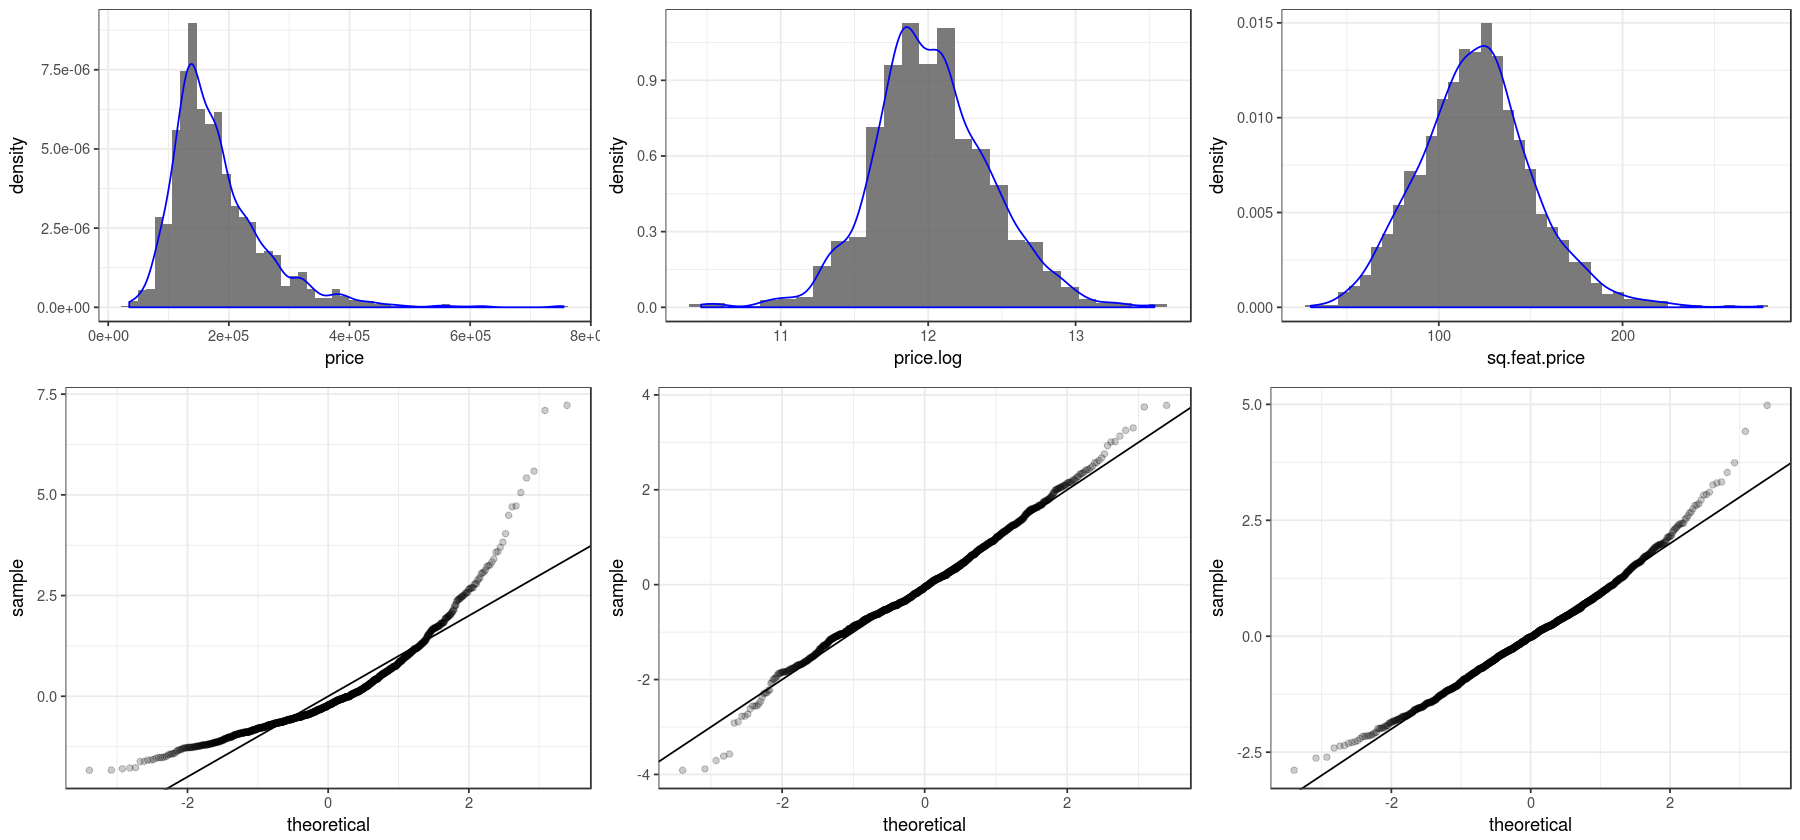

In [7]:
p1 <- 
    trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p2 <- 
    trainset %>% 
    ggplot(aes(price.log)) +
    geom_histogram(aes(y=..density..), binwidth=0.12, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p3 <- 
    trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- 
    trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- 
    trainset %>% 
    mutate(
        price.log.norm = (price.log - mean(price.log)) / sd(price.log)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=price.log.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- 
    trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

grid.arrange(
    p1, p2, p3, qq1, qq2, qq3, 
    layout_matrix=rbind(c(1, 2, 3), c(4, 5, 6)),
    heights=c(45, 55))

### Single variable vs target $R^2$

In [82]:
r2.target.vs.vars <- 
    trainset %>%
    gather(var.name, var.value, -price, -price.log, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(price.log ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

r2.target.vs.vars %>% arrange(desc(r2)) %>% head(12) %>% t
r2.target.vs.vars %>% arrange(desc(r2.log)) %>% head(12) %>% t
r2.target.vs.vars %>% arrange(desc(r2.sq.feat)) %>% head(12) %>% t

CORR <-
    trainset %>% 
    select(-Id, -price, -price.log, -sq.feat.price) %>%
    cor(trainset %>% select(-Id, -price, -price.log, -sq.feat.price)) %>%
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    left_join(r2.target.vs.vars, by='var.name') %>%
    gather(correlation.with, corr, -var.name, -r2, -r2.log, -r2.sq.feat) %>%
    filter(var.name != correlation.with) %>%
    mutate(
       max.r2 = pmax(r2, r2.log, r2.sq.feat)
    ) %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    as.tibble

CORR %>% head

[,1]        [,2]    [,3]      [,4]         [,5]     [,6]     
var.name   OverallQual quality GrLivArea Neighborhood log.area ExterQual
r2         0.633       0.621   0.540     0.523        0.494    0.471    
r2.log     0.675       0.657   0.526     0.572        0.544    0.466    
r2.sq.feat 0.240       0.234   0.007     0.292        0.011    0.250    
           [,7]     [,8]        [,9]        [,10]      [,11]     [,12]     
var.name   BsmtQual KitchenQual TotalBsmtSF GarageCars X1stFlrSF GarageArea
r2         0.454    0.446       0.424       0.411      0.399     0.396     
r2.log     0.455    0.451       0.419       0.464      0.385     0.431     
r2.sq.feat 0.302    0.244       0.229       0.166      0.093     0.170

[,1]        [,2]    [,3]         [,4]     [,5]      [,6]     
var.name   OverallQual quality Neighborhood log.area GrLivArea ExterQual
r2         0.633       0.621   0.523        0.494    0.540     0.471    
r2.log     0.675       0.657   0.572        0.544    0.526     0.466    
r2.sq.feat 0.240       0.234   0.292        0.011    0.007     0.250    
           [,7]       [,8]     [,9]        [,10]      [,11]       [,12]    
var.name   GarageCars BsmtQual KitchenQual GarageArea TotalBsmtSF X1stFlrSF
r2         0.411      0.454    0.446       0.396      0.424       0.399    
r2.log     0.464      0.455    0.451       0.431      0.419       0.385    
r2.sq.feat 0.166      0.302    0.244       0.170      0.229       0.093

[,1]      [,2]     [,3]         [,4]      [,5]        [,6]       
var.name   YearBuilt BsmtQual Neighborhood ExterQual KitchenQual OverallQual
r2         0.274     0.454    0.523        0.471     0.446       0.633      
r2.log     0.345     0.455    0.572        0.466     0.451       0.675      
r2.sq.feat 0.317     0.302    0.292        0.250     0.244       0.240      
           [,7]    [,8]        [,9]         [,10]        [,11]      [,12]     
var.name   quality TotalBsmtSF BsmtFinType1 YearRemodAdd BsmtFinSF1 Foundation
r2         0.621   0.424       0.209        0.258        0.168      0.255     
r2.log     0.657   0.419       0.228        0.320        0.154      0.304     
r2.sq.feat 0.234   0.229       0.214        0.208        0.201      0.187

var.name    r2    r2.log r2.sq.feat correlation.with corr   max.r2
1 LotArea     0.072 0.068  0.013      LotFrontage       0.072 0.072 
2 Street      0.002 0.003  0.000      LotFrontage      -0.026 0.003 
3 Alley       0.015 0.018  0.031      LotFrontage      -0.042 0.031 
4 LotShape    0.072 0.084  0.037      LotFrontage       0.166 0.084 
5 LandContour 0.001 0.000  0.000      LotFrontage      -0.020 0.001 
6 Utilities   0.000 0.000  0.000      LotFrontage       0.044 0.000

### Quality

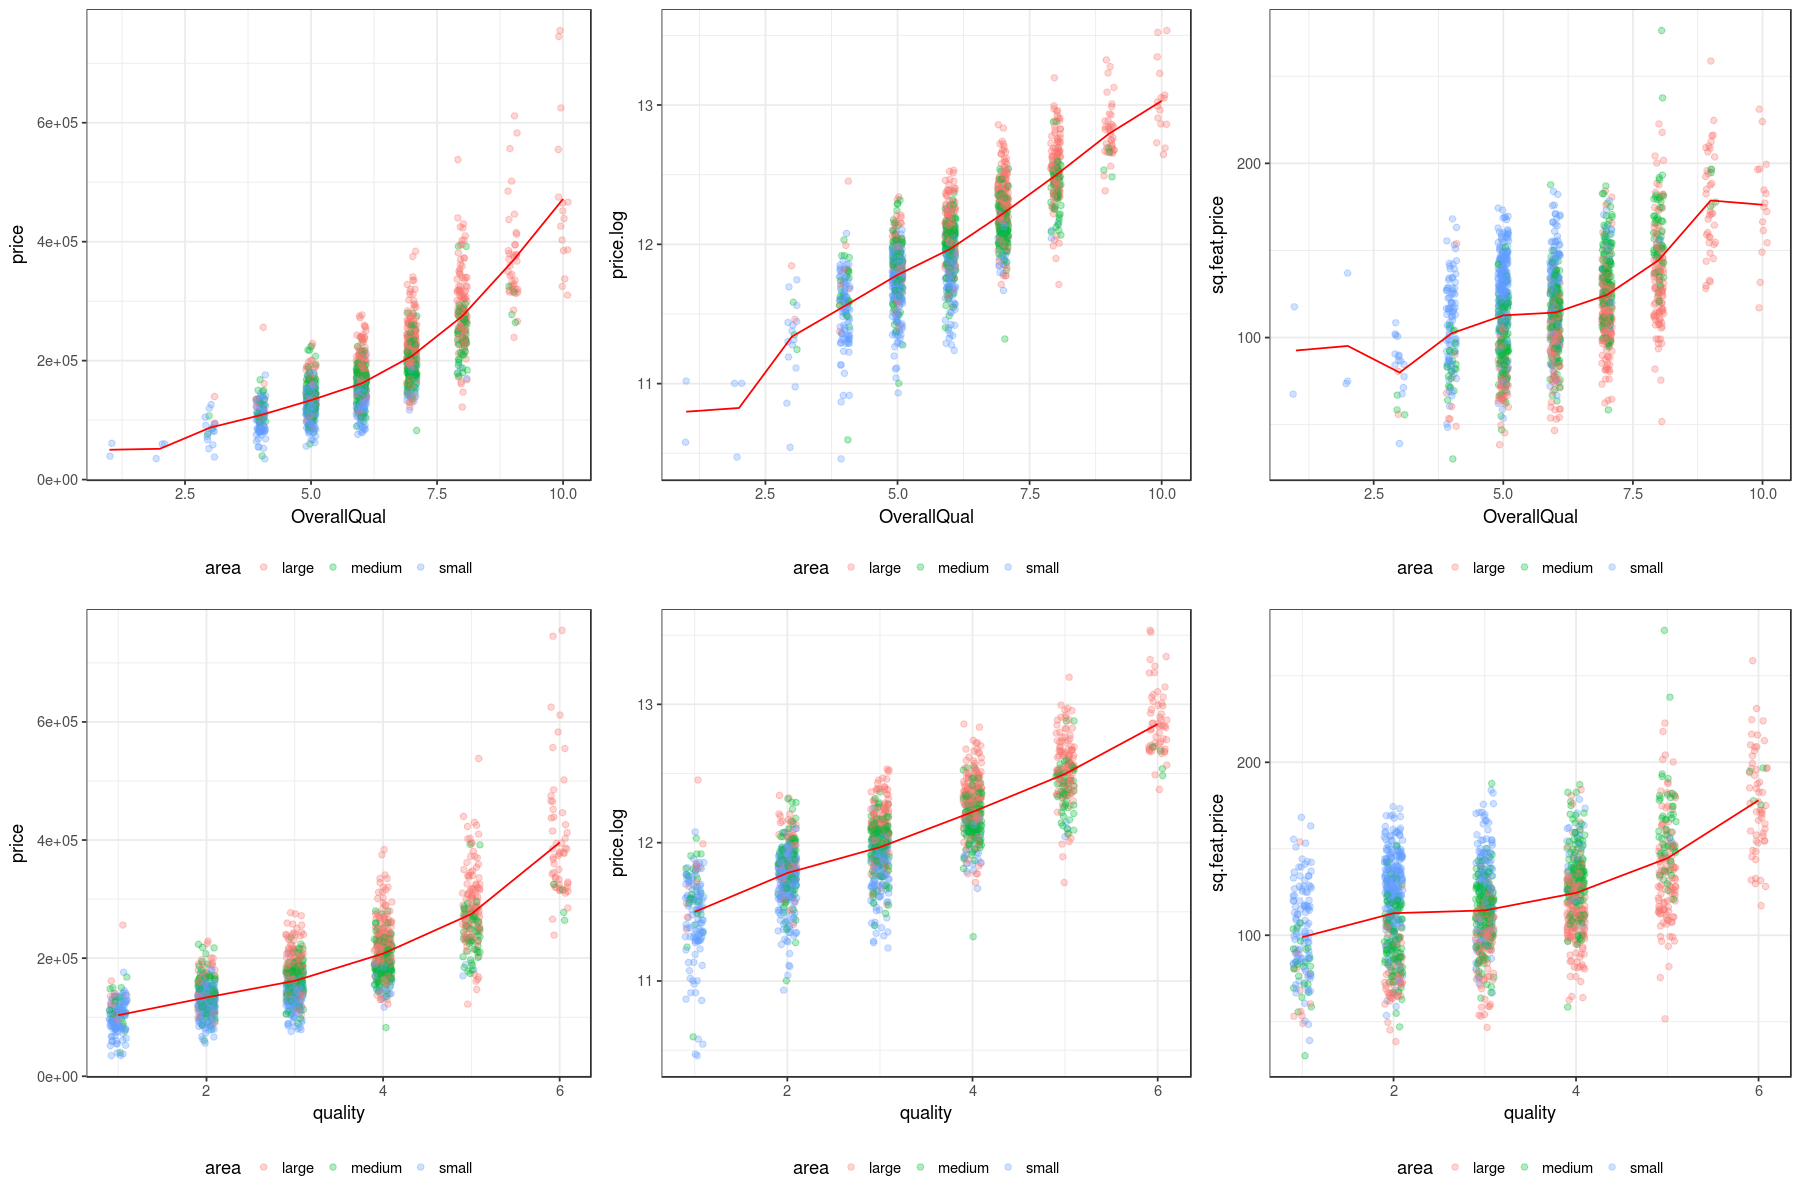

In [23]:
source('main.R')

df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

jitter <- purrr::partial(kaggle.house$plot$jitter, color.var="area")

grob1 <- 
    arrangeGrob(
        df %>% jitter("OverallQual", "price"), 
        df %>% jitter("OverallQual", "price.log"), 
        df %>% jitter("OverallQual", "sq.feat.price"), 
        layout_matrix=rbind(c(1, 2, 3))
    )

grob2 <- 
    arrangeGrob(
        df %>% jitter("quality", "price"), 
        df %>% jitter("quality", "price.log"), 
        df %>% jitter("quality", "sq.feat.price"), 
        layout_matrix=rbind(c(1, 2, 3))
    )

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(grob1, grob2) %>% grid.draw

### price.log ~ quality

[[1]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6565905     0.6563546 0.2343183  2783.836       0  2 47.85559 -89.71117
        BIC deviance df.residual
1 -73.85671 79.94176        1456

[[2]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6600165     0.6595491 0.2332266  1412.309       0  3 55.16486 -102.3297
        BIC deviance df.residual
1 -81.19043 79.14423        1455

[[3]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6636814     0.6629875 0.2320459  956.4274       0  4 63.06607 -116.1321
        BIC deviance df.residual
1 -89.70803 78.29106        1454

[[1]]
         term   estimate   std.error statistic p.value
1 (Intercept) 11.2511479 0.015881523 708.44261       0
2     quality  0.2489134 0.004717658  52.76207       0

[[2]]
         term   estimate   std.error  statistic      p.value
1 (Intercept) 11.3630041 0.033215016 342.104430 0.000000e+00
2     quality  0.1682582 0.021580926   7.796615 1.203635e-14
3    quality2  0.0122278 0.003193405   3.829078 1.340868e-04

[[3]]
          term    estimate   std.error  statistic       p.value
1  (Intercept) 11.16311558 0.036587847 305.104465  0.000000e+00
2      quality  0.26640037 0.009498919  28.045336 1.059594e-138
3  quality.low  0.08091608 0.023061334   3.508734  4.639704e-04
4 quality.high  0.09584357 0.037783663   2.536641  1.129602e-02

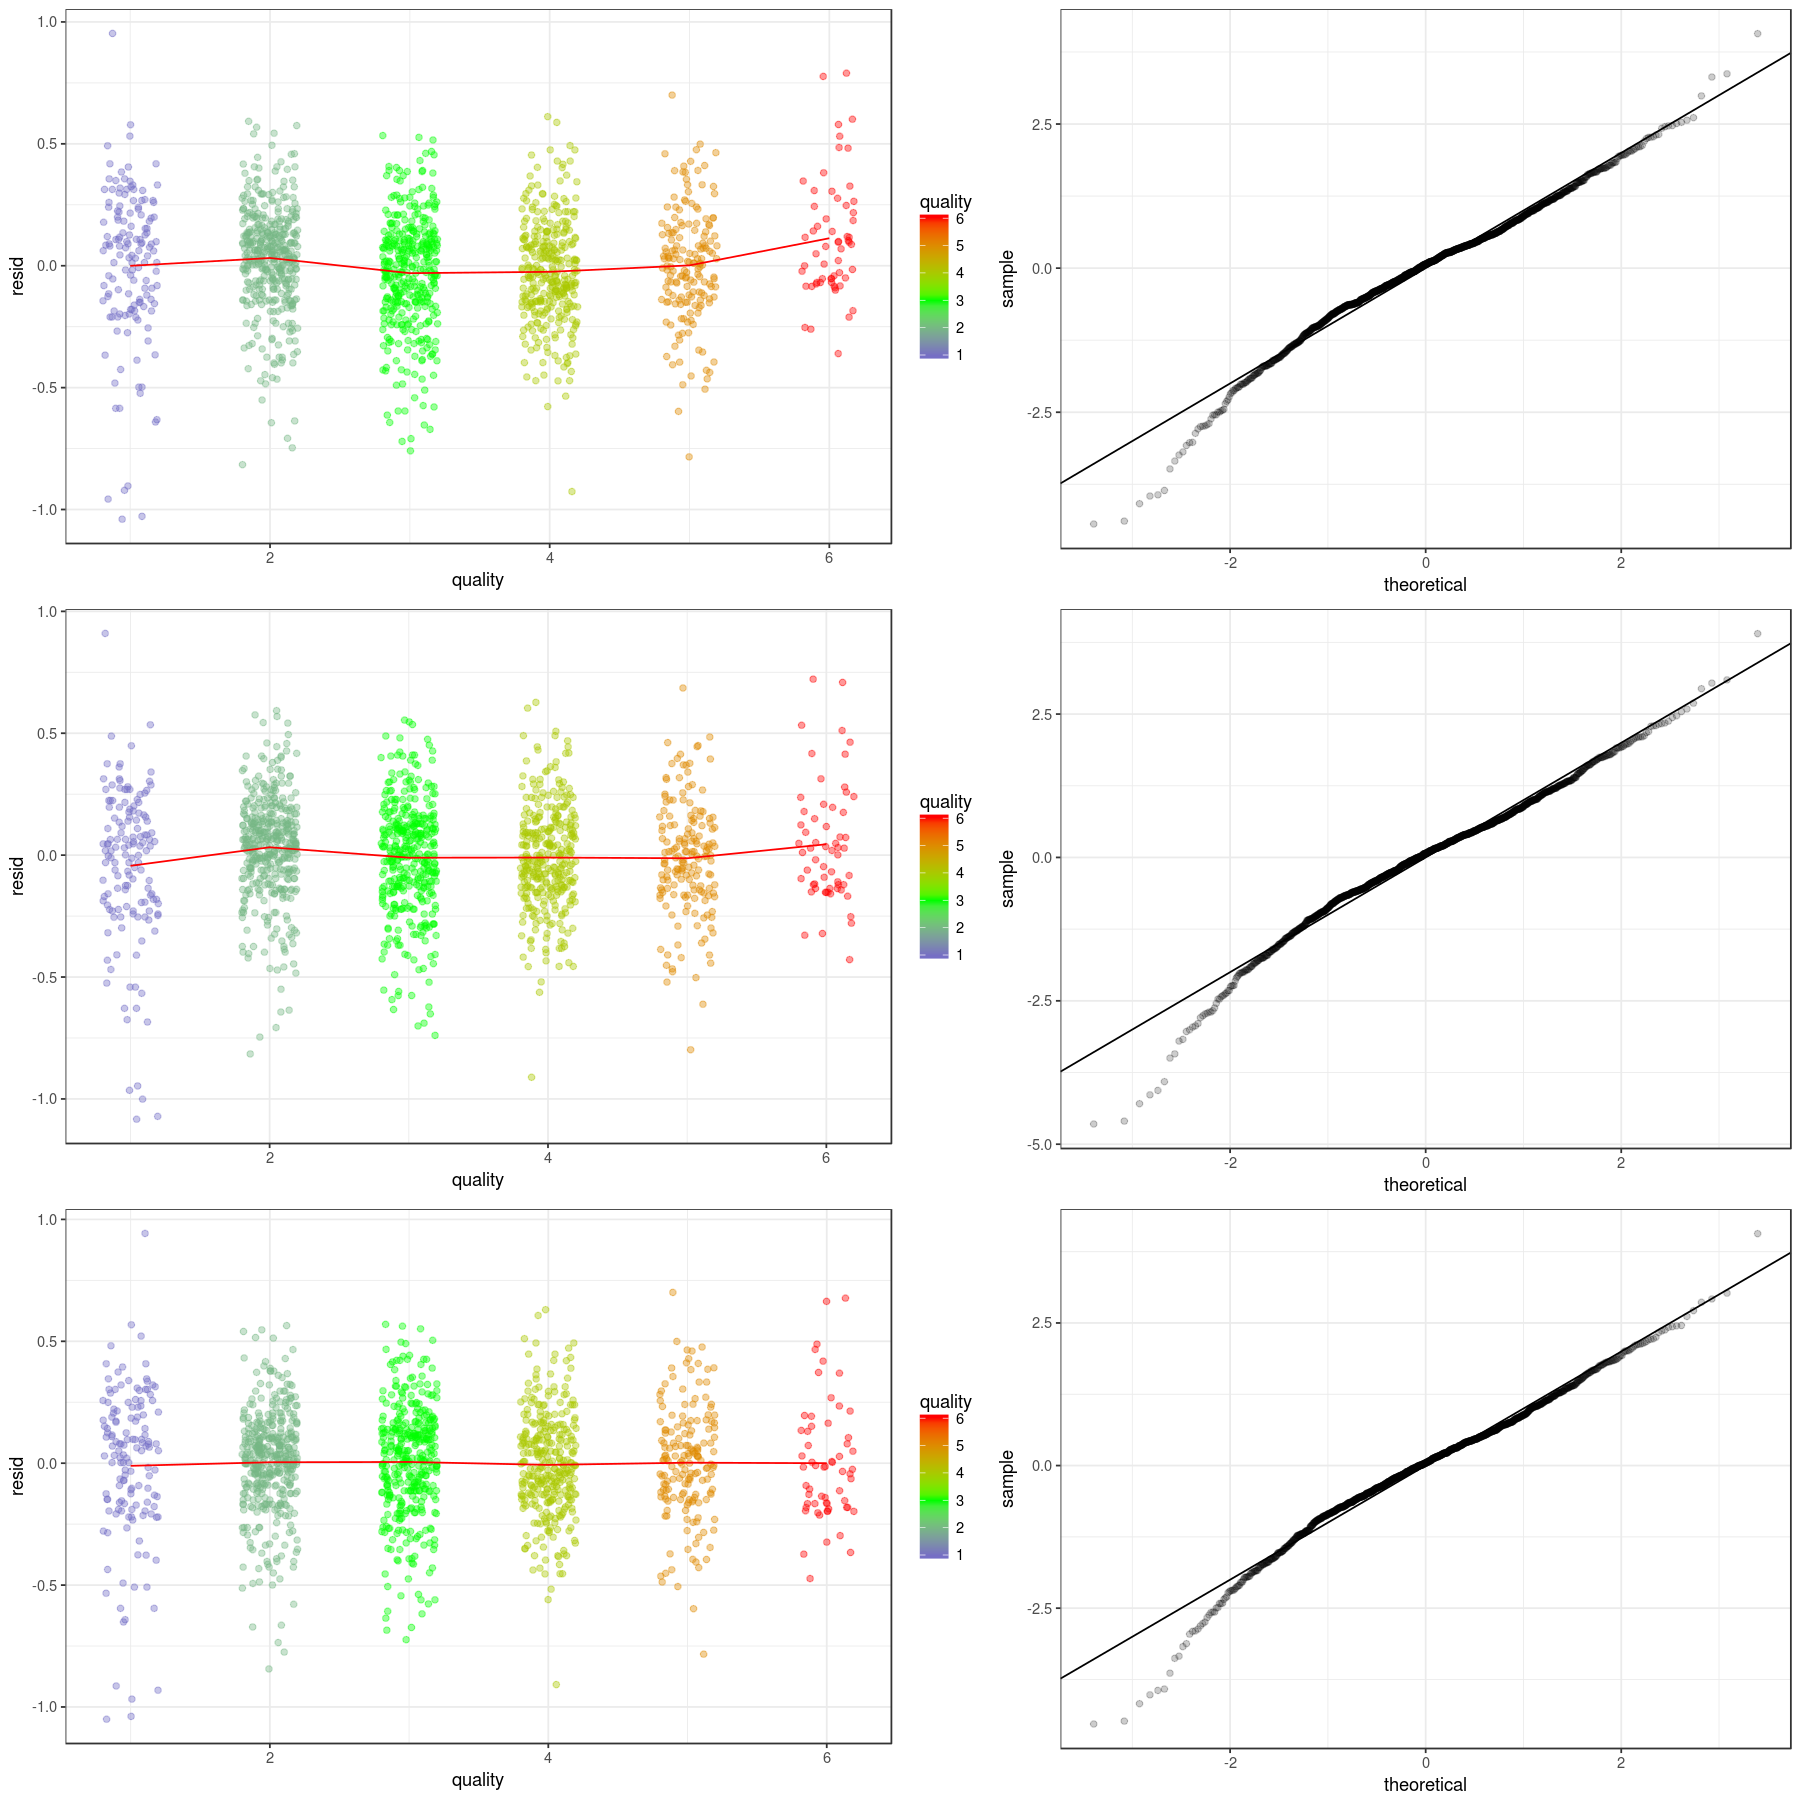

In [121]:
mods <- list()

df <- 
    trainset %>%
    mutate(
        quality2 = quality^2,
        quality.low = ifelse(quality <= 2, 1, 0),
        quality.high = ifelse(quality == 6, 1, 0)
    )

mods <-
  c(price.log ~ quality, 
    price.log ~ quality + quality2, 
    price.log ~ quality + quality.low + quality.high) %>% map(function (formula) { lm(formula, data=df) })

mods %>% map(glance)
mods %>% map(tidy)

grobs <- 
    mods %>% 
    map(function (model) {
        df <- 
            model %>% 
            augment %>% 
            select(price.log, quality, resid=.resid)
        
        p <- 
            df %>%
            ggplot(aes(x=quality, y=resid)) +
            geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
            scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
            stat_summary(fun.y = mean, geom="line", colour = "red") +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()

        grob <- arrangeGrob(p, qq, layout_matrix=rbind(c(1, 2)), widths=c(55, 45))
    })

      
options(repr.plot.width = 15, repr.plot.height = 15)
arrangeGrob(grobs=grobs) %>% grid.draw

### Greedy prodictor selection: price.log ~ quality + ???

In [95]:
CORR %>%
    filter(correlation.with == "quality") %>%
    filter(max.r2 > 0.1) %>%
    arrange(desc(r2.log/abs(corr))) %>%
    head(10) %>%
    mutate(
        formula = paste0("price.log ~ quality + ", var.name),
        mod = map(formula, ~lm(as.formula(.), trainset)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
    ) %>%
    select(-mod, -glance) %>%
    arrange(desc(r2))

var.name     r2        r2.log r2.sq.feat correlation.with corr  max.r2
1  log.area     0.7546350 0.544  0.011      quality          0.601 0.544 
2  GrLivArea    0.7531223 0.526  0.007      quality          0.584 0.540 
3  X1stFlrSF    0.7331583 0.385  0.093      quality          0.463 0.399 
4  Neighborhood 0.7261225 0.572  0.292      quality          0.701 0.572 
5  TotalBsmtSF  0.7234069 0.419  0.229      quality          0.528 0.424 
6  GarageArea   0.7178963 0.431  0.170      quality          0.556 0.431 
7  GarageCars   0.7151237 0.464  0.166      quality          0.602 0.464 
8  BsmtFinSF1   0.7080967 0.154  0.201      quality          0.210 0.201 
9  TotRmsAbvGrd 0.7056644 0.289  0.031      quality          0.415 0.289 
10 MSSubClass   0.7008928 0.331  0.068      quality          0.482 0.331 
   formula                           
1  price.log ~ quality + log.area    
2  price.log ~ quality + GrLivArea   
3  price.log ~ quality + X1stFlrSF   
4  price.log ~ quality + Neighborhood
5  price.log ~ quality + TotalBsmtSF 
6  price.log ~ quality + GarageArea  
7  price.log ~ quality + GarageCars  
8  price.log ~ quality + BsmtFinSF1  
9  price.log ~ quality + TotRmsAbvGrd
10 price.log ~ quality + MSSubClass

### Area

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.525931  0.5256054     0.2753092 1615.283  2.966447e-238 2  -187.1954
  AIC      BIC      deviance df.residual
1 380.3908 396.2453 110.3578 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

term        estimate  std.error  statistic p.value      
1 (Intercept) 5.5415392 0.15576391 35.57653  5.072263e-200
2 log.area    0.8921619 0.02141518 41.66025  2.079661e-250

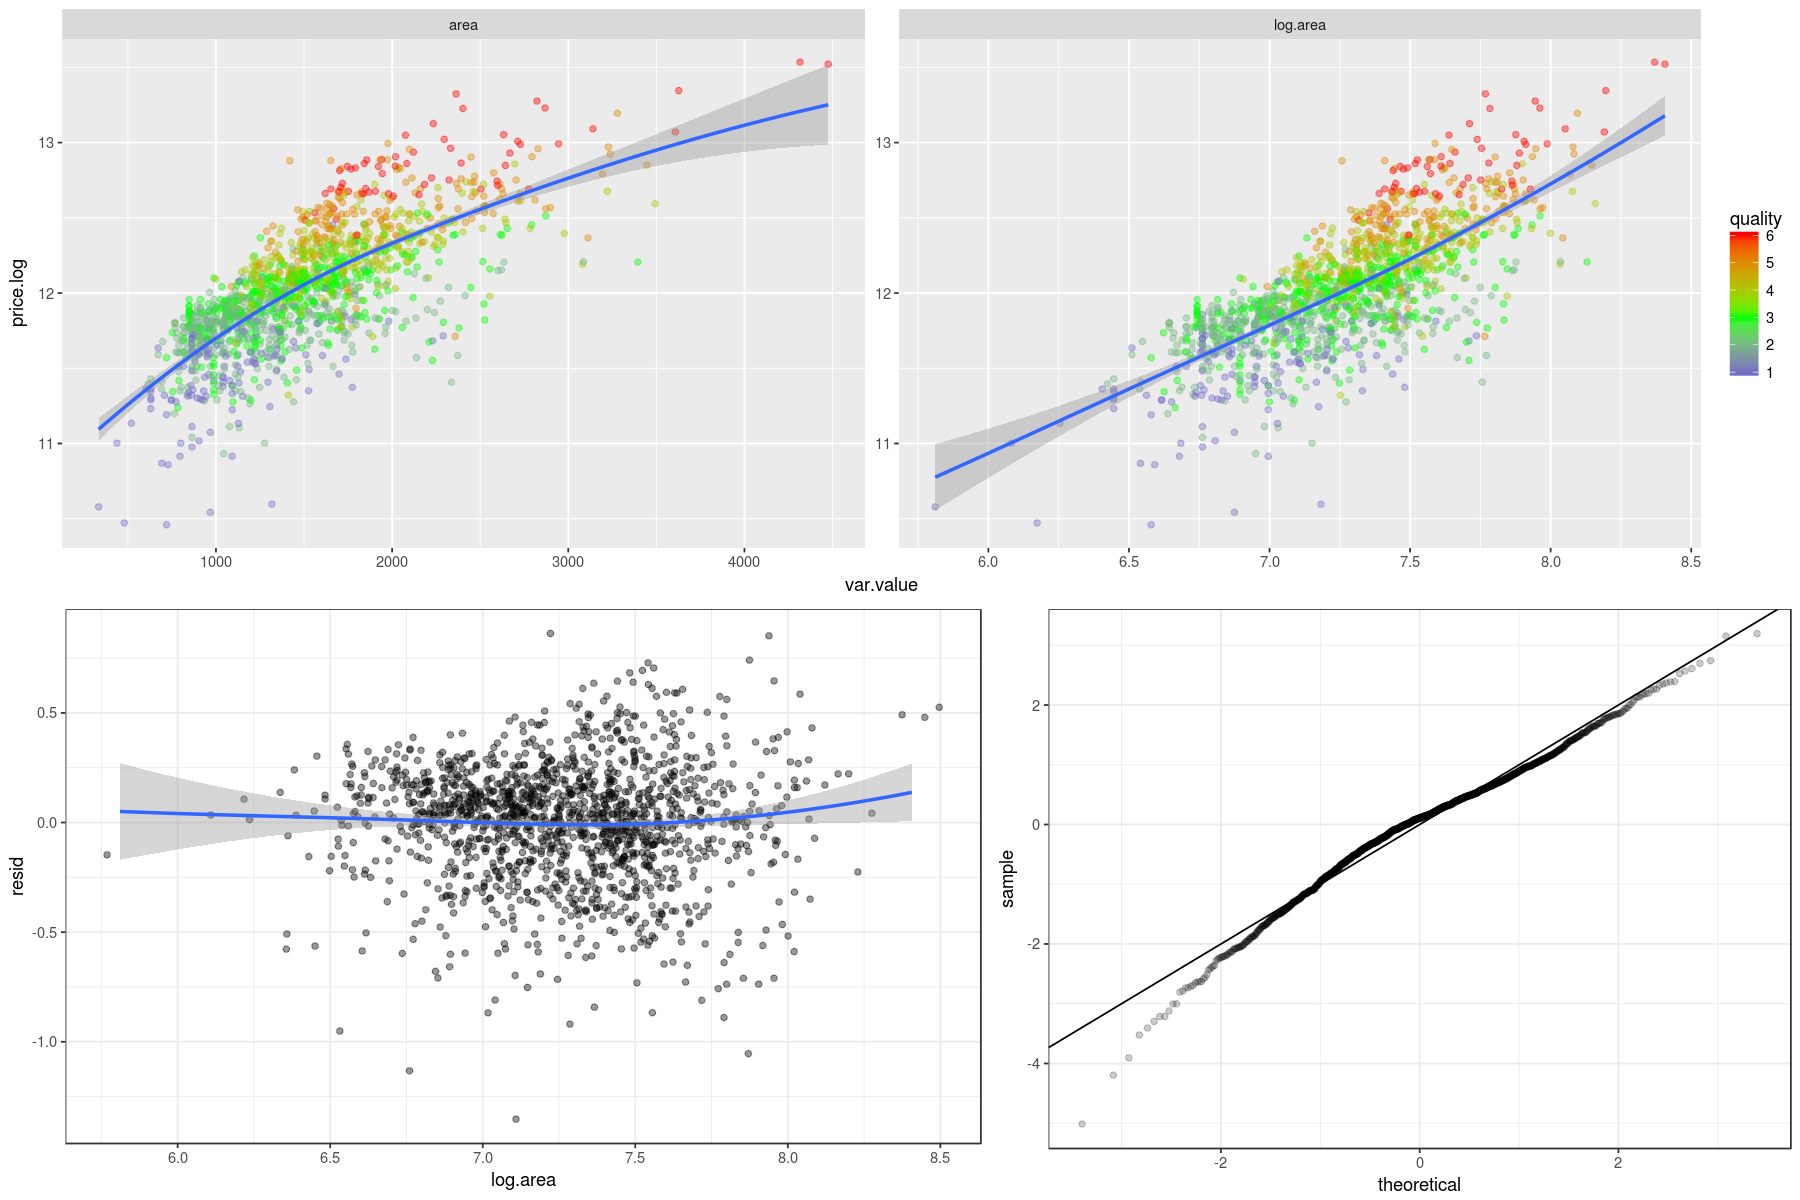

In [110]:
lm(price.log ~ GrLivArea, data=trainset) %>% glance
lm(price.log ~ log.area, data=trainset) %>% glance

p <- 
    trainset %>% 
    rename(area=GrLivArea) %>%
    select(area, log.area, price.log, quality) %>%
    gather(var.name, var.value, -price.log, -quality) %>% 
    ggplot(aes(x=var.value, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~var.name, ncol=2, scales="free")

gr1 <- arrangeGrob(p)

mod <- lm(price.log ~ log.area, data=trainset)
mod %>% glance
mod %>% tidy

gr2 <- 
    mod %>% 
    augment %>% 
    select(price.log, log.area, resid=.resid) %>%
    (function (df) {
        p <- 
            df %>%
            ggplot(aes(x=log.area, y=resid)) +
            geom_jitter(alpha=0.4, width=0.2, height=0) +
            geom_smooth(method = "loess", span = 1) +
            theme_bw()

        qq <-
            df %>% 
            mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
            ggplot() +
            geom_qq(aes(sample=resid.norm), alpha=0.2) +
            geom_abline(slope=1) +
            theme_bw()
        
        arrangeGrob(p, qq, layout_matrix=rbind(c(1, 2)), widths=c(55, 45))
    })

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(gr1, gr2) %>% grid.draw

### price.log ~ quality + log.area

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.754635  0.7542977     0.1981324 2237.47   0       3  292.9283 -577.8566
  BIC       deviance df.residual
1 -556.7173 57.11814 1455

term        estimate  std.error   statistic p.value      
1 (Intercept) 8.0310149 0.134221393 59.83409   0.000000e+00
2 quality     0.1765286 0.004992495 35.35879  3.470013e-198
3 log.area    0.4741085 0.019662604 24.11219  2.383194e-108

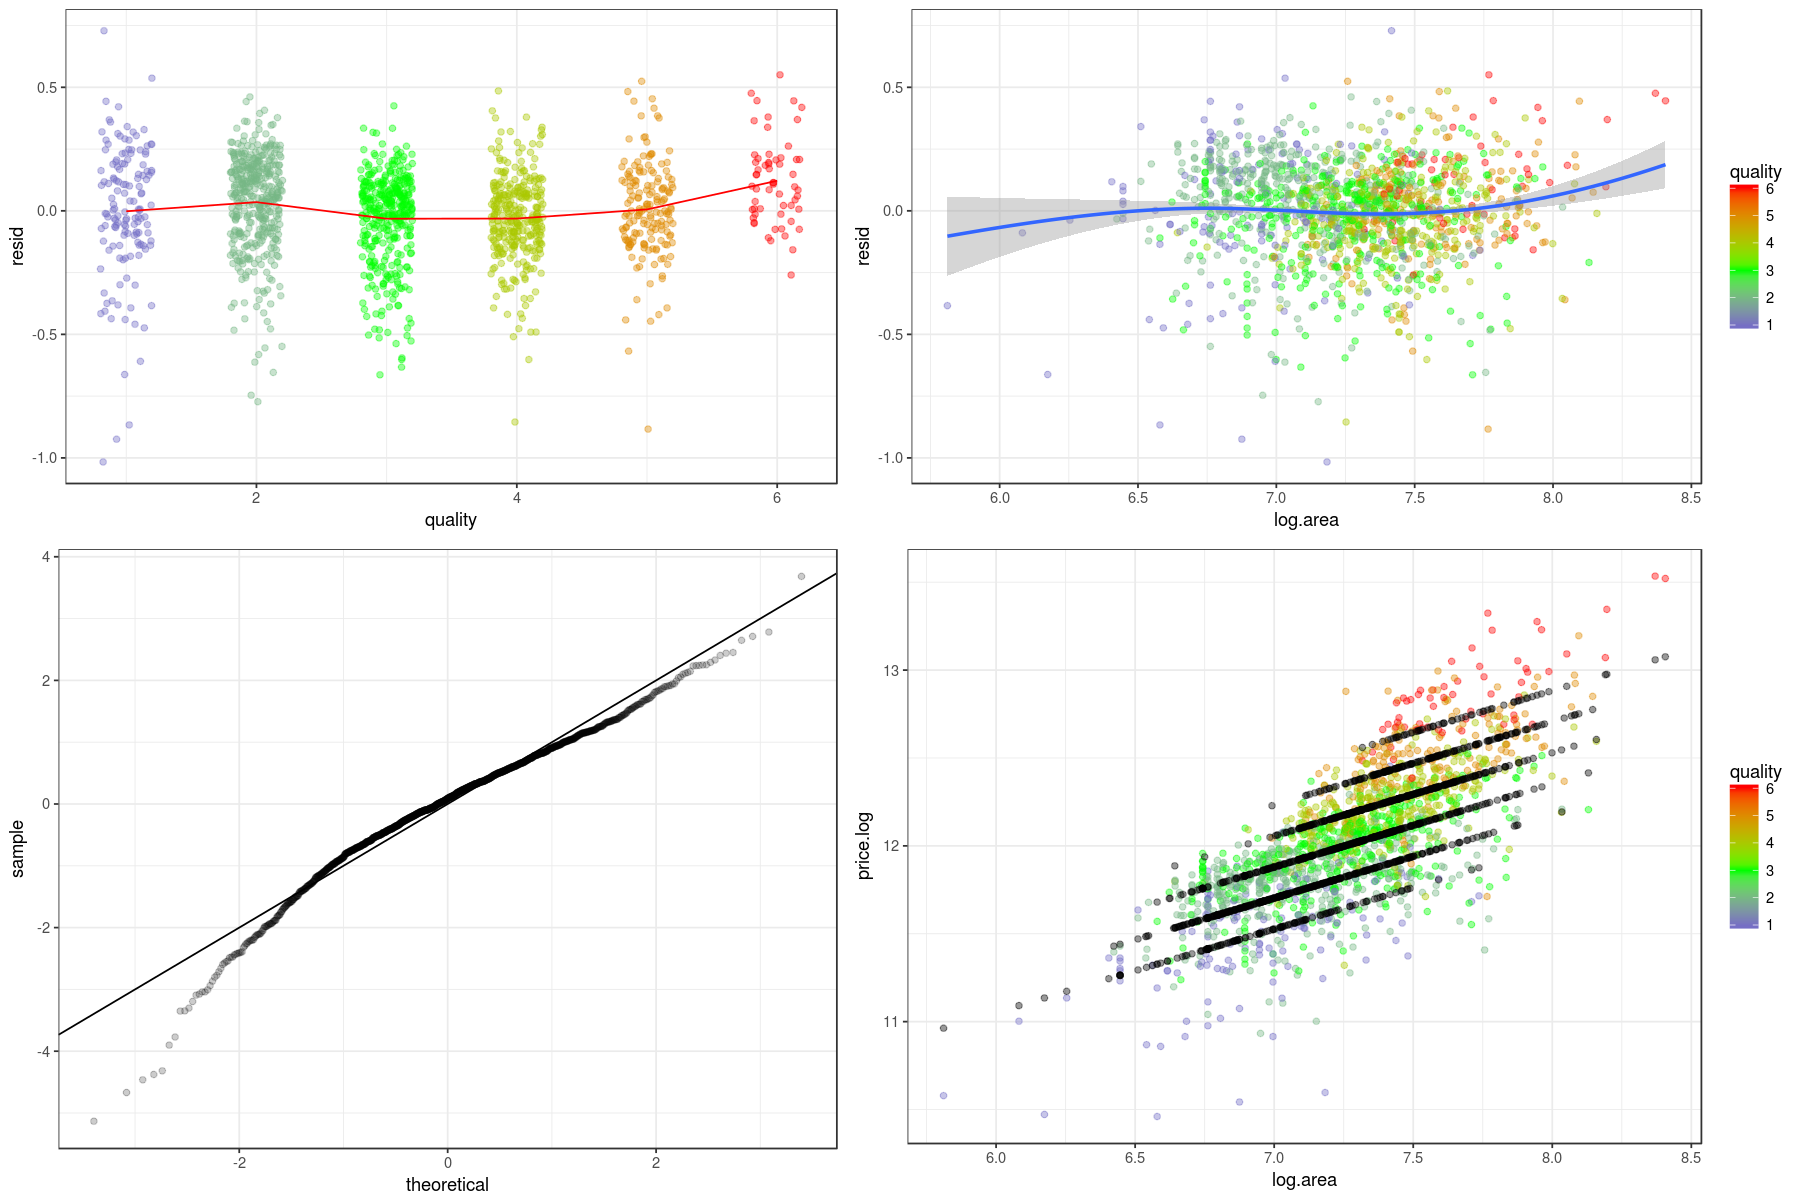

In [143]:
mod <- lm(price.log ~ quality + log.area, data=trainset)

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    rename(resid=.resid, fitted=.fitted)

p1 <-
    df %>% 
    ggplot(aes(x=quality, y=resid)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="none")

p2 <- 
    df %>% 
    ggplot(aes(x=log.area, y=resid)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

qq <-
    df %>% 
    mutate(resid.norm = (resid - mean(resid)) / sd(resid)) %>%
    ggplot() +
    geom_qq(aes(sample=resid.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

fit <-
    df %>%
    ggplot() +
    geom_point(aes(x=log.area, y=price.log, color=quality), alpha=0.4) +
    geom_point(aes(x=log.area, y=fitted), color="black", alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 10)
arrangeGrob(
    p1, p2, qq, fit, 
    layout_matrix=rbind(c(1, 2), c(3, 4)), 
    widths=c(47, 53),
    heights=c(45, 55)) %>% grid.draw

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.3446195 0.3441694     0.323703 765.6103  9.084861e-136 2  -423.2915 852.583
  BIC      deviance df.residual
1 868.4375 152.565  1456

term        estimate    std.error    statistic p.value      
1 (Intercept) -3.29527359 0.5537139284 -5.95122   3.329151e-09
2 YearBuilt    0.00777148 0.0002808664 27.66966  9.084861e-136

r.squared adj.r.squared sigma   statistic p.value       df logLik   AIC    
1 0.4076478 0.4068335     0.30785 500.6544  3.564239e-166 3  -349.579 707.158
  BIC      deviance df.residual
1 728.2973 137.8927 1455

term        estimate      std.error    statistic p.value     
1 (Intercept)  3.862348e+02 3.131074e+01  12.33554 2.530705e-33
2 YearBuilt   -3.894084e-01 3.192224e-02 -12.19866 1.170740e-32
3 YearBuilt2   1.012188e-04 8.134896e-06  12.44254 7.570087e-34

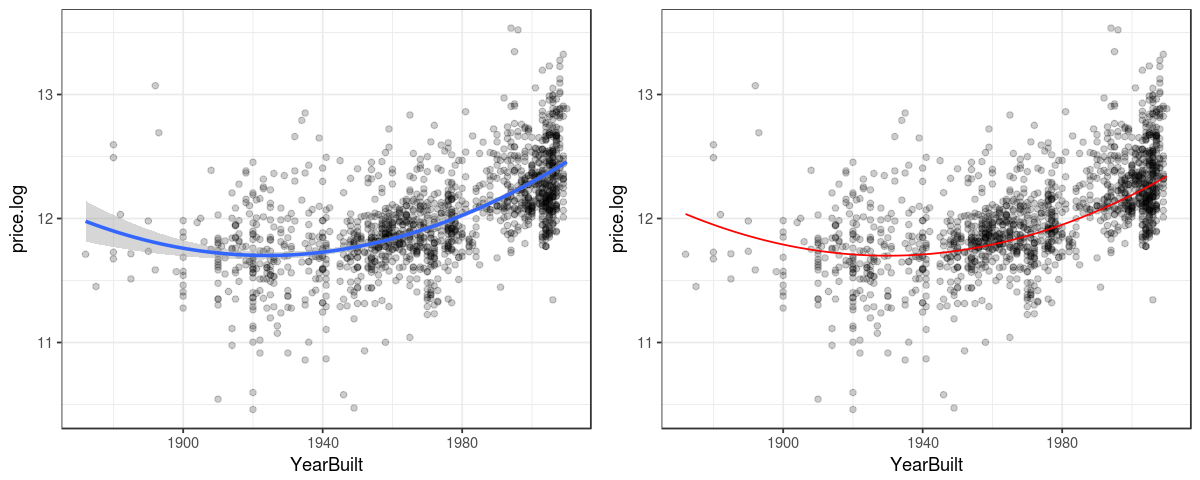

In [37]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod1 <- lm(price.log ~ YearBuilt, data=trainset) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(price.log ~ YearBuilt + YearBuilt2, data=trainset %>% mutate(YearBuilt2 = YearBuilt^2))
mod2 %>% glance
mod2 %>% tidy

p1 <- 
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <-
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_function(fun = function (x) { 11.7 + 0.0001*(x - 1930)^2 }, colour = "red") +
    theme_bw()

grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7981759 0.7976203     0.1798185 1436.584  0       5  435.3388 -858.6775
  BIC       deviance df.residual
1 -826.9686 46.98232 1453

term        estimate      std.error    statistic p.value      
1 (Intercept) -7.355761e+01 2.072396e+01 -3.549399  3.984138e-04
2 log.area     5.327632e-01 1.815045e-02 29.352624 4.287568e-149
3 quality      1.310197e-01 5.938149e-03 22.064063  2.798099e-93
4 year         7.971236e-02 2.117362e-02  3.764702  1.733940e-04
5 year2       -1.950972e-05 5.410639e-06 -3.605807  3.217093e-04

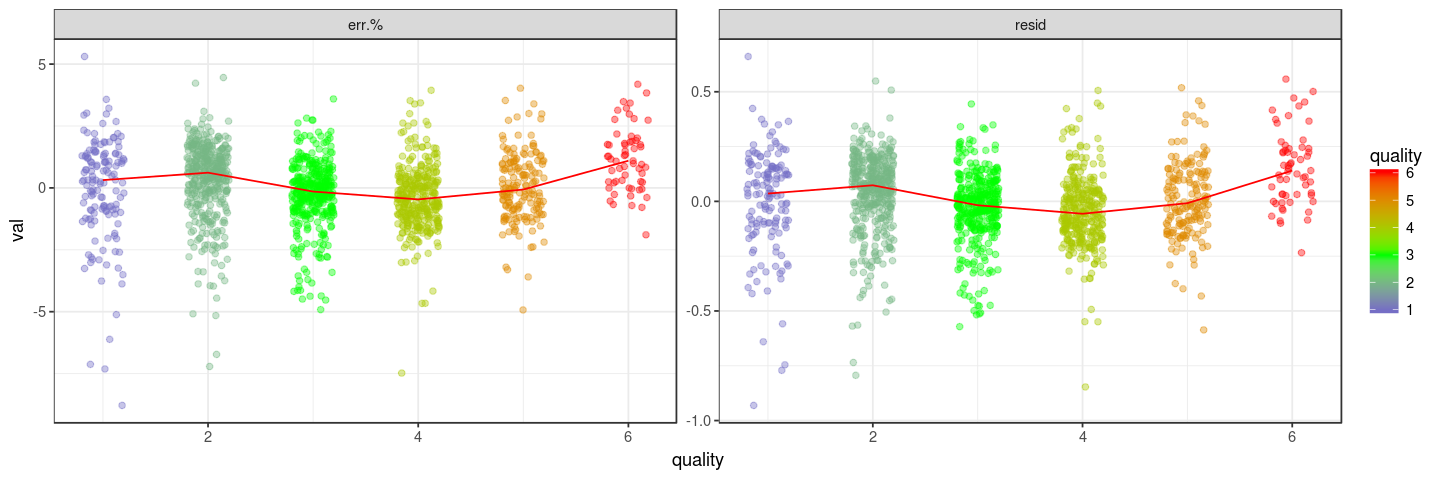

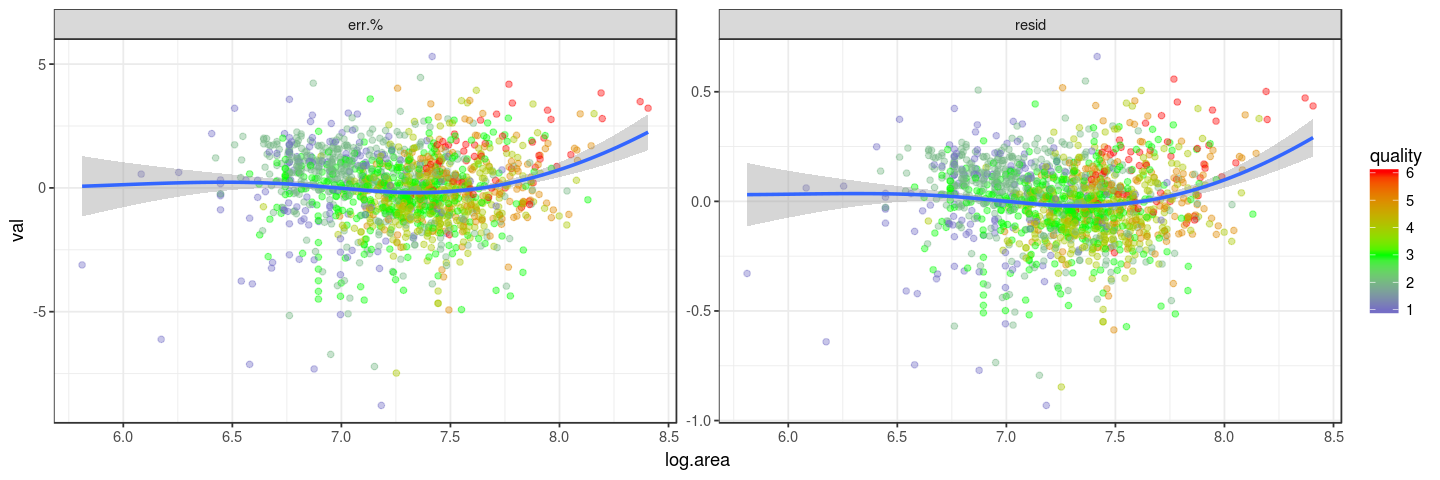

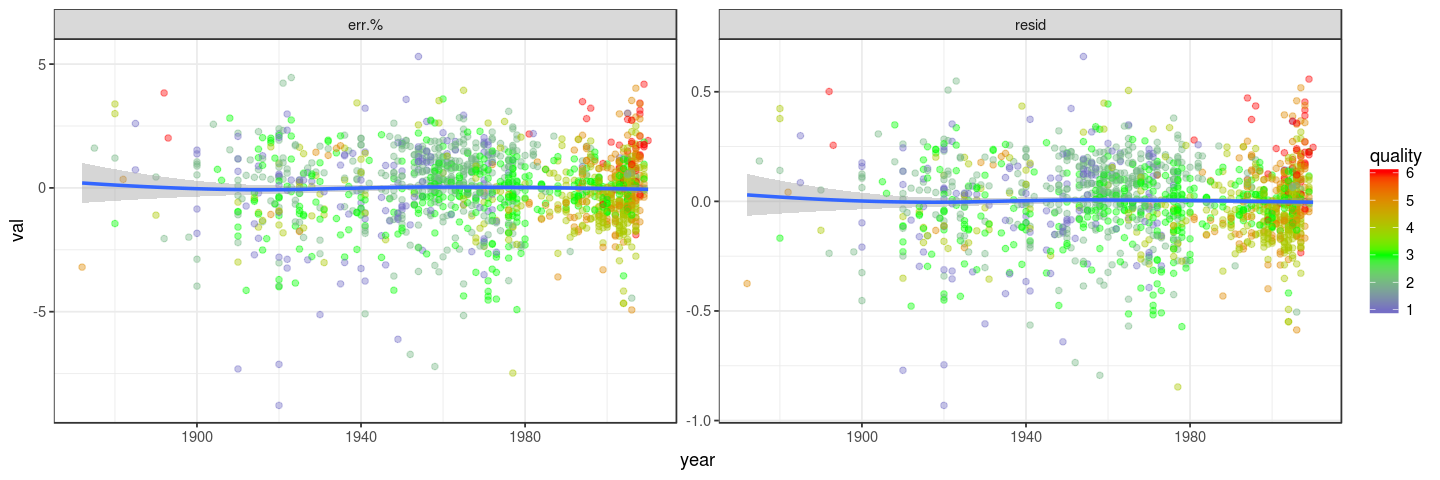

In [39]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
    price.log ~ log.area + quality + year + year2, 
    data=trainset %>% 
         rename(year=YearBuilt) %>%
         mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5718582 0.5715642     0.2616338 1944.743  1.726602e-270 2  -112.9113
  AIC      BIC      deviance df.residual
1 231.8226 247.6771 99.66645 1456

term         estimate std.error   statistic  p.value      
1 (Intercept)  12.02401 0.006851963 1754.82675  0.000000e+00
2 Neighborhood  1.00000 0.022676129   44.09924 1.726602e-270

mean(price.log)
1 12.02401

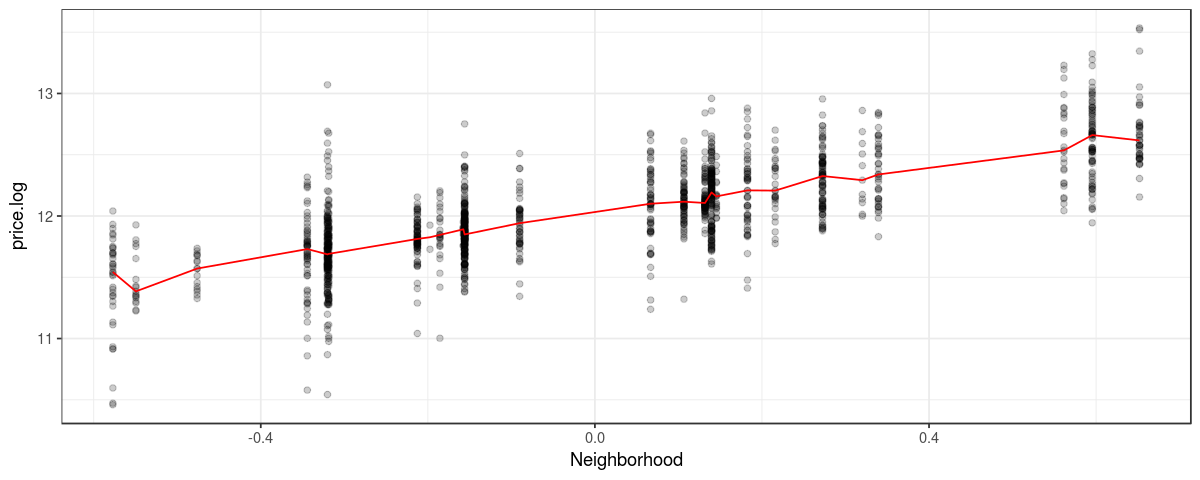

In [45]:
options(repr.plot.width = 10, repr.plot.height = 4)

mod <- lm(price.log ~ Neighborhood, data=trainset) 
mod %>% glance
mod %>% tidy

trainset %>% summarise(mean(price.log))

trainset %>%
    ggplot(aes(x=Neighborhood, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8221211 0.8215086     0.1688727 1342.172  0       6  527.4069 -1040.814
  BIC      deviance df.residual
1 -1003.82 41.40814 1452

term        estimate      std.error    statistic p.value      
1 (Intercept) -8.819613e+01 1.949061e+01 -4.525056  6.530337e-06
2 log.area     4.817378e-01 1.743195e-02 27.635332 1.980469e-135
3 quality      1.063733e-01 5.848691e-03 18.187534  9.441095e-67
4 year         9.665210e-02 1.992163e-02  4.851615  1.356494e-06
5 year2       -2.421977e-05 5.092443e-06 -4.756022  2.170774e-06
6 hood         3.346765e-01 2.393837e-02 13.980758  9.150030e-42

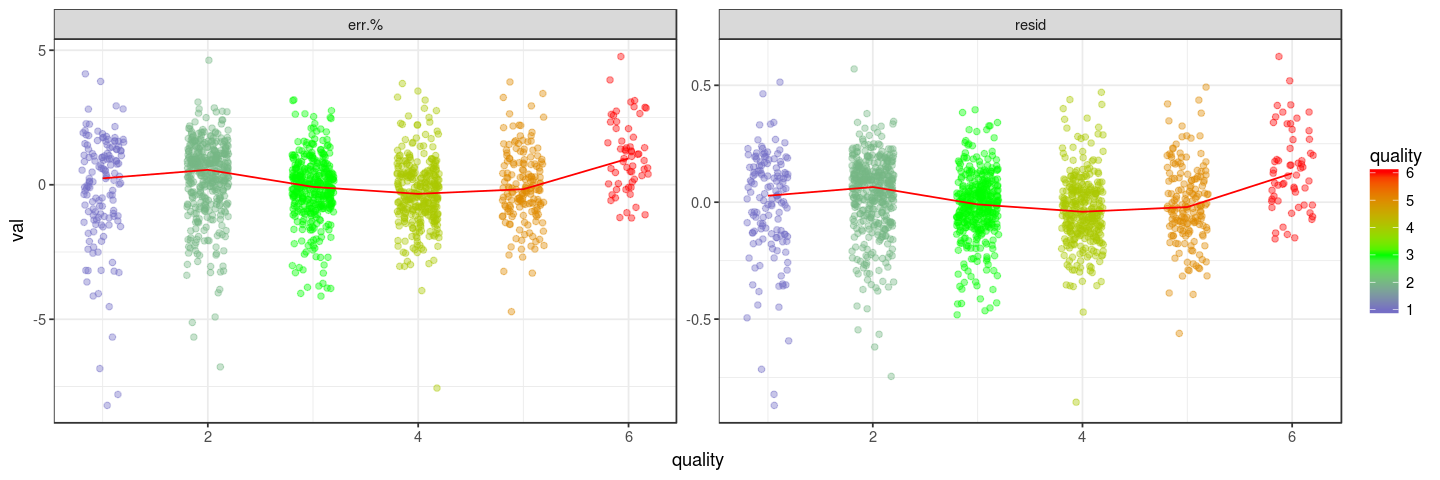

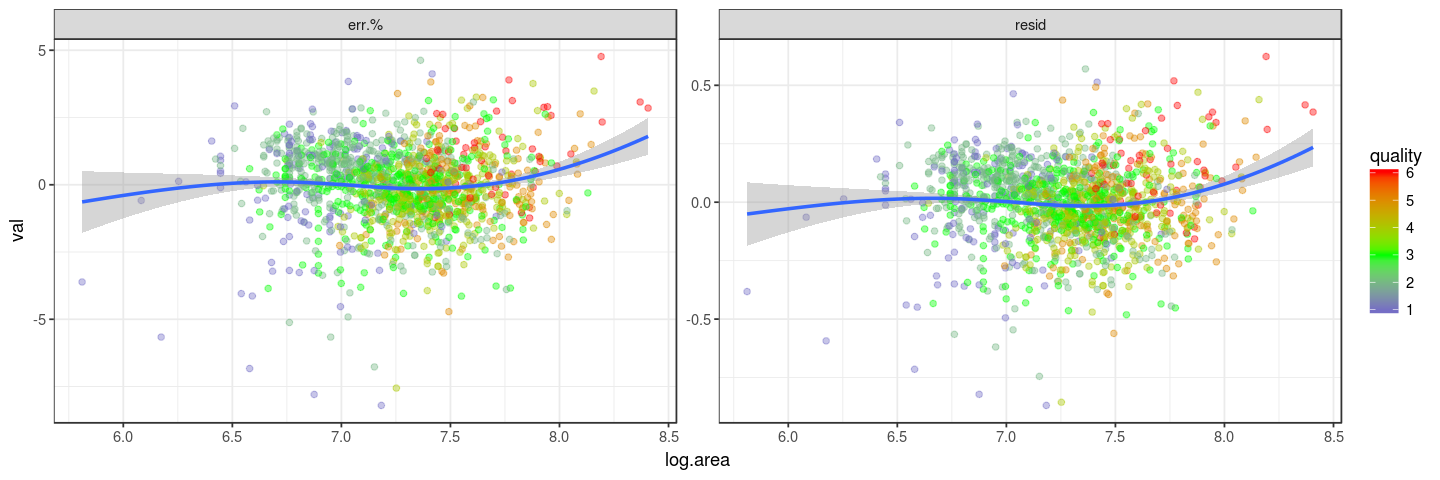

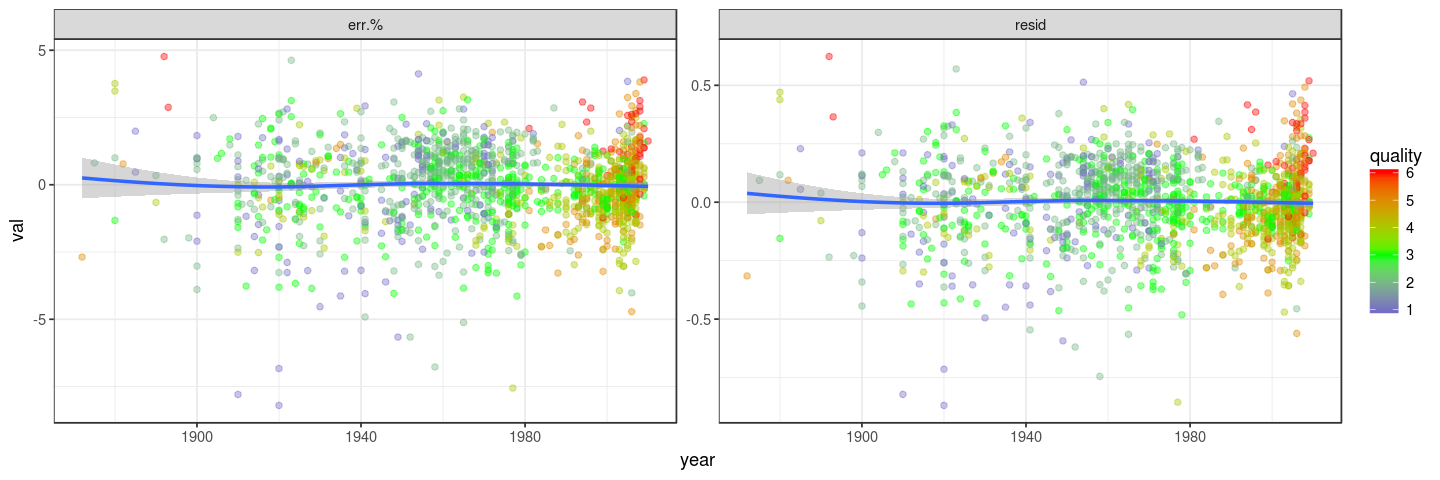

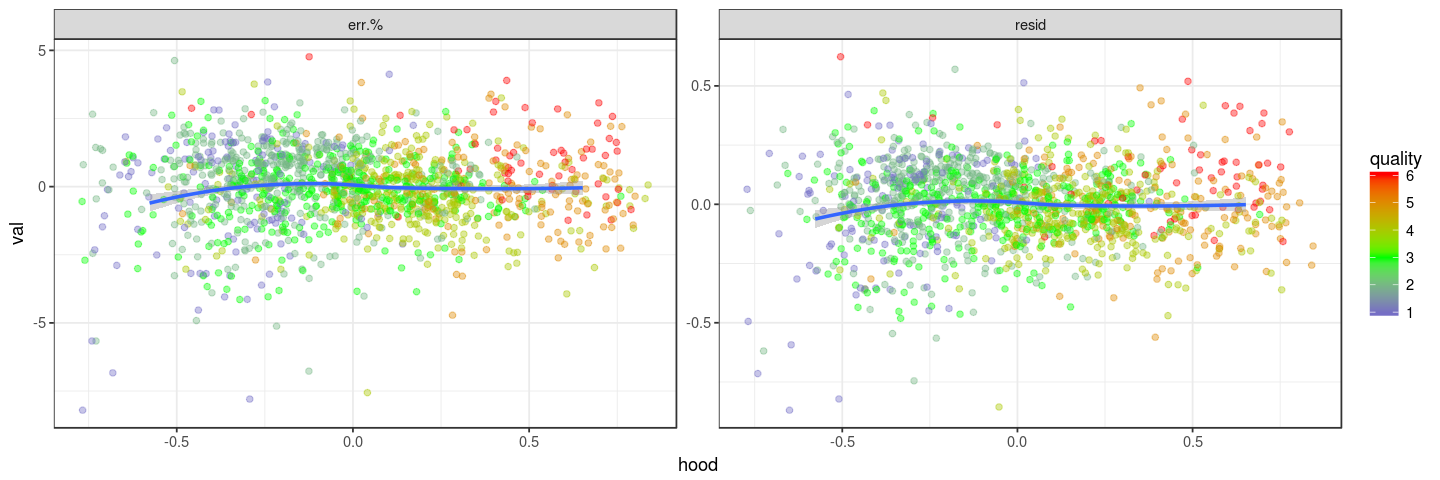

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(year2 = year^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

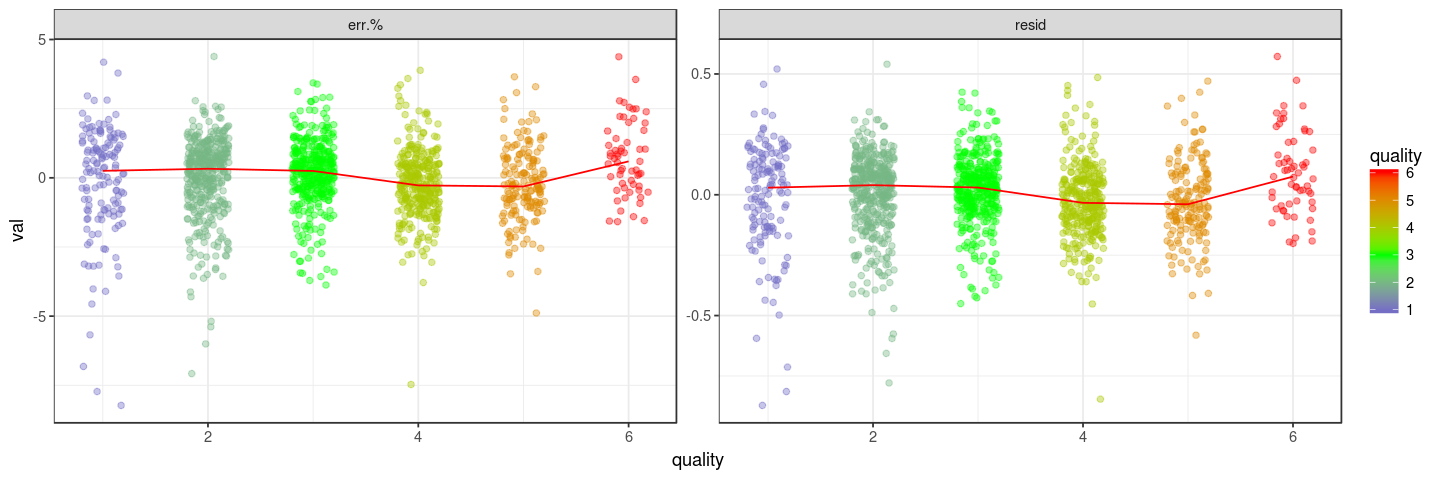

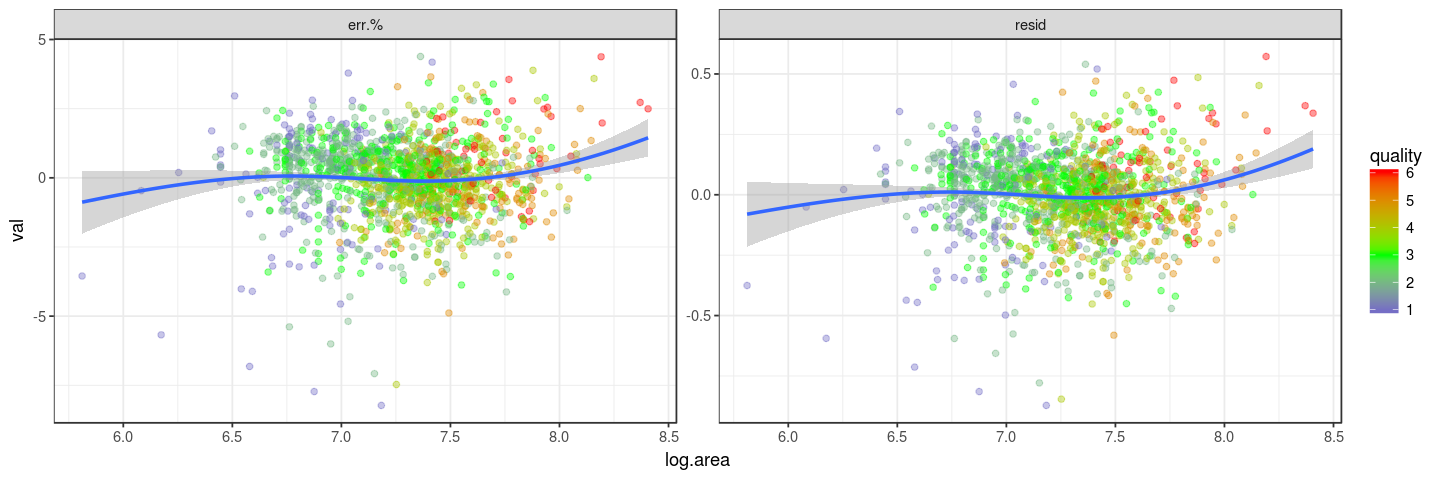

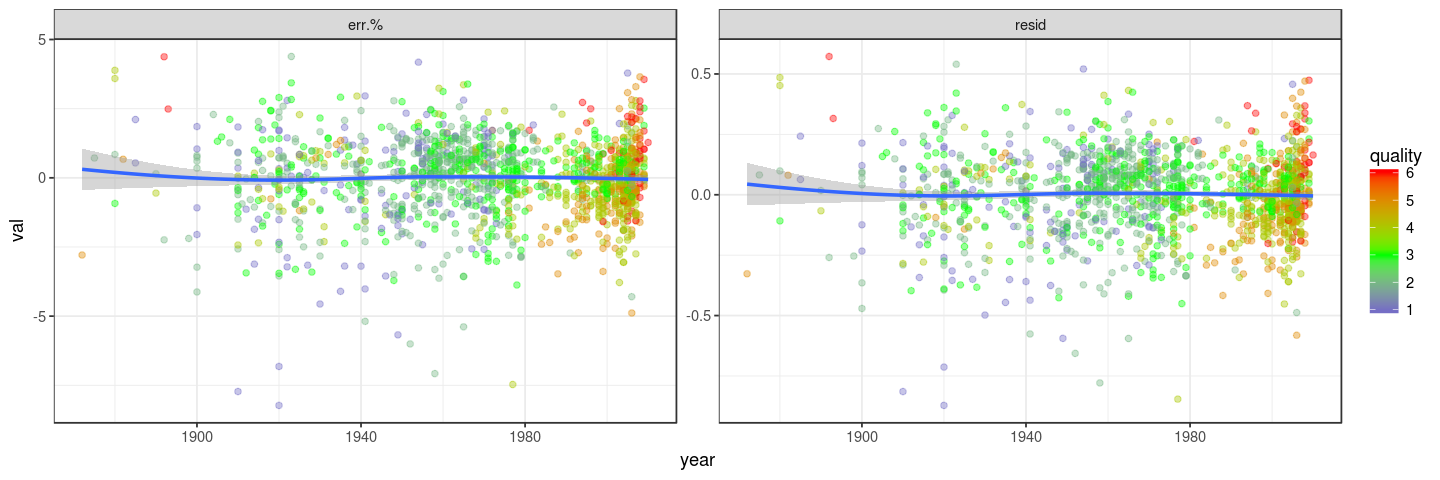

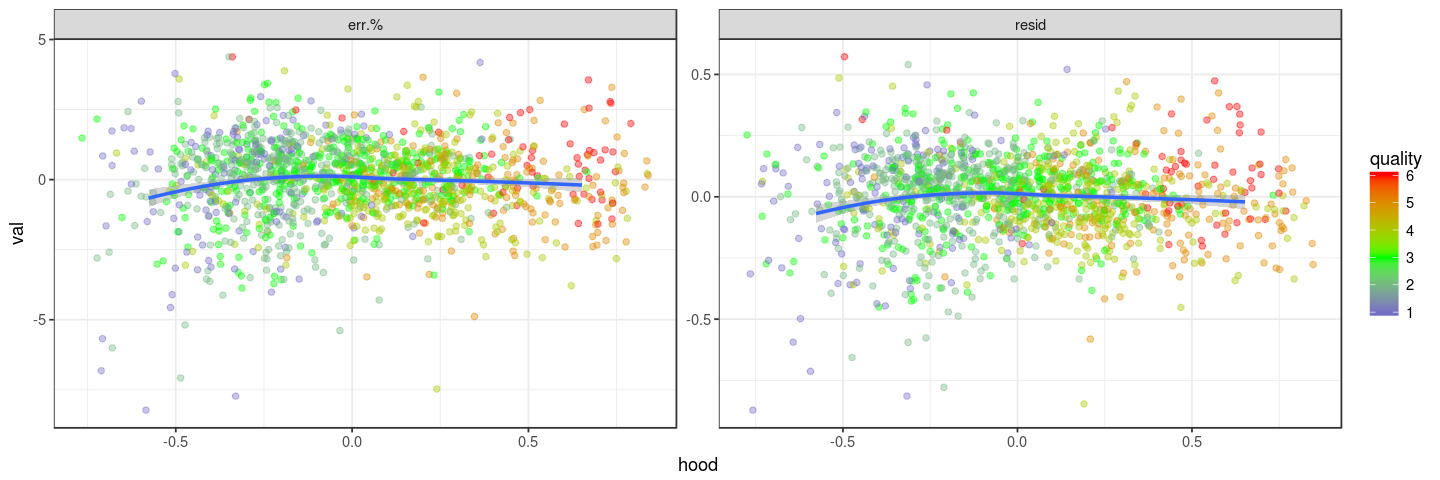

In [55]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -hood)

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

In [102]:
X <- trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -YearBuilt, -Neighborhood,
           -price, -price.log, -sq.feat.price) %>%
    cor(trainset %>% select(log.area, quality, YearBuilt, Neighborhood)) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>% 
    left_join(target.vs.vars, by='var.name') %>%
    filter(r2 > 0.1 | r2.log > 0.1 | r2.sq.feat > 0.1) %>%
    mutate(
        max.corr = pmax(log.area %>% abs, quality %>% abs, YearBuilt %>% abs, Neighborhood %>% abs),
        max.r2 = pmax(r2, r2.log, r2.sq.feat),
        max.r2/max.corr
    ) %>%
    mutate_if(is.numeric, funs(round(., 3)))

X %>% arrange(max.corr, desc(max.r2)) %>% head(10)

X %>% arrange(desc(`max.r2/max.corr`)) %>% head(10)

var.name      log.area quality YearBuilt Neighborhood r2    r2.log
1  BsmtFullBath  0.010    0.101   0.185     0.156        0.052 0.056 
2  WoodDeckSF    0.239    0.233   0.224     0.251        0.105 0.112 
3  GarageYrBlt   0.208    0.275   0.272     0.273        0.068 0.122 
4  BsmtFinSF1    0.130    0.210   0.250     0.277        0.168 0.154 
5  OpenPorchSF   0.305    0.295   0.184     0.215        0.103 0.106 
6  BsmtExposure  0.127    0.306   0.256     0.263        0.147 0.143 
7  SaleType      0.162    0.337   0.345     0.329        0.139 0.122 
8  GarageCond    0.205    0.294   0.346     0.295        0.081 0.145 
9  GarageQual    0.205    0.287   0.347     0.286        0.081 0.141 
10 SaleCondition 0.157    0.330   0.349     0.328        0.135 0.130 
   r2.sq.feat max.corr max.r2 max.r2/max.corr
1  0.125      0.185    0.125  0.676          
2  0.042      0.251    0.112  0.447          
3  0.054      0.275    0.122  0.444          
4  0.201      0.277    0.201  0.725          
5  0.015      0.305    0.106  0.348          
6  0.181      0.306    0.181  0.591          
7  0.127      0.345    0.139  0.403          
8  0.074      0.346    0.145  0.419          
9  0.073      0.347    0.141  0.407          
10 0.136      0.349    0.136  0.389

var.name     log.area quality YearBuilt Neighborhood r2    r2.log r2.sq.feat
1  TotalBsmtSF  0.419    0.528   0.400     0.502        0.424 0.419  0.229     
2  GarageArea   0.467    0.556   0.478     0.542        0.396 0.431  0.170     
3  GarageCars   0.497    0.602   0.537     0.589        0.411 0.464  0.166     
4  X1stFlrSF    0.539    0.463   0.281     0.443        0.399 0.385  0.093     
5  BsmtFinSF1   0.130    0.210   0.250     0.277        0.168 0.154  0.201     
6  BsmtFullBath 0.010    0.101   0.185     0.156        0.052 0.056  0.125     
7  KitchenQual  0.424    0.675   0.525     0.585        0.446 0.451  0.244     
8  BsmtQual     0.387    0.687   0.690     0.656        0.454 0.455  0.302     
9  ExterQual    0.437    0.724   0.596     0.657        0.471 0.466  0.250     
10 GarageFinish 0.387    0.567   0.616     0.560        0.301 0.382  0.183     
   max.corr max.r2 max.r2/max.corr
1  0.528    0.424  0.803          
2  0.556    0.431  0.776          
3  0.602    0.464  0.771          
4  0.539    0.399  0.740          
5  0.277    0.201  0.725          
6  0.185    0.125  0.676          
7  0.675    0.451  0.668          
8  0.690    0.455  0.659          
9  0.724    0.471  0.651          
10 0.616    0.382  0.620

In [113]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(
        price.log ~ log.area + quality + quality.low + year + year2 + hood, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod %>% glance
mod %>% tidy

mod2 <- lm(
        price.log ~ log.area + quality + year + hood + BsmtFinSF1, 
        data=trainset %>% 
             rename(year=YearBuilt, hood=Neighborhood) %>%
             mutate(
                 year2 = year^2,
                 quality.low = ifelse(quality <= 2, 1, 0)
             ))

mod2 %>% glance
mod2 %>% tidy

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8269207 0.826205      0.1666363 1155.407  0       7  547.3472 -1078.694
  BIC       deviance df.residual
1 -1036.416 40.29086 1451

term        estimate      std.error    statistic p.value      
1 (Intercept) -9.285568e+01 1.924651e+01 -4.824546  1.551102e-06
2 log.area     4.884481e-01 1.723359e-02 28.342792 5.276353e-141
3 quality      1.366929e-01 7.493589e-03 18.241312  4.286005e-67
4 quality.low  9.761569e-02 1.538891e-02  6.343250  2.998806e-10
5 year         1.010947e-01 1.967027e-02  5.139463  3.130416e-07
6 year2       -2.532011e-05 5.027994e-06 -5.035828  5.354120e-07
7 hood         3.126350e-01 2.387555e-02 13.094354  4.117207e-37

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC     
1 0.8508438 0.8503301     0.1546387 1656.552  0       6  655.7901 -1297.58
  BIC       deviance df.residual
1 -1260.586 34.72184 1452

term        estimate     std.error    statistic p.value      
1 (Intercept) 4.9705324427 4.213149e-01 11.79767   9.670567e-31
2 log.area    0.4772489589 1.595649e-02 29.90940  1.522554e-153
3 quality     0.0966003165 5.030250e-03 19.20388   2.021721e-73
4 year        0.0016288015 1.940926e-04  8.39188   1.120235e-16
5 hood        0.2800897118 2.203708e-02 12.70993   3.607664e-35
6 BsmtFinSF1  0.0001711674 9.775669e-06 17.50953   1.986886e-62